# Анализ и изграждане на модел на данни от състезанието Spooky Authors Identification на платформата kaggle.com
# Ще разгледаме набор от данни свързани с трима автори и по - точно, абзаци от техните най - известни произведения

<strong>Да заредим малко библиотеки</strong>

![](https://pa1.narvii.com/6530/6738a896c5702e4c9f220f26f5eb06085432ac47_hq.gif)

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
from IPython.display import display
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD,Adam


Using TensorFlow backend.


Да заредим данните и да видим тяхната форма

In [2]:
train = pd.read_csv("data/spooky/train.zip", index_col=['id'])
test = pd.read_csv("data/spooky/test.zip", index_col=['id'])
sample_submission = pd.read_csv("data/spooky/sample_submission.zip", index_col=['id'])

print(train.shape, test.shape, sample_submission.shape)
print(set(train.columns) - set(test.columns))

(19579, 2) (8392, 1) (8392, 3)
{'author'}


In [3]:
train.head(10)


,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL
id22965,"A youth passed in solitude, my best years spen...",MWS
id09674,"The astronomer, perhaps, at this point, took r...",EAP
id13515,The surcingle hung in ribands from my body.,EAP
id19322,I knew that you could not say to yourself 'ste...,EAP


In [4]:
print('Обща информация за тренировъчните данни:')
display(train.info())

print('Обща информация за тестовите данни:')
display(test.info())

Обща информация за тренировъчните данни:
<class 'pandas.core.frame.DataFrame'>
Index: 19579 entries, id26305 to id00393
Data columns (total 2 columns):
text      19579 non-null object
author    19579 non-null object
dtypes: object(2)
memory usage: 458.9+ KB


None

Обща информация за тестовите данни:
<class 'pandas.core.frame.DataFrame'>
Index: 8392 entries, id02310 to id04282
Data columns (total 1 columns):
text    8392 non-null object
dtypes: object(1)
memory usage: 131.1+ KB


None

Виждаме, че данните са "чисти" и няма празни стойности, набора от тренировъчни данни е 19579, докато тези за тестване са 8392

<strong>Сега малко повече информация за авторите</strong>

# Авторите

### EAP - Едгар Алън По 
* Американски писател, малко мрачен, представител на романтизма
* Най-голям успех му нови поемата "Гарванът"
* Роден е на 19 януари 1809 г.
* Активен период 1827 – 1849

### HPL - Хауърд Филипс Лъвкрафт 
* Американски писател, главно пише фантастика и ужаси
* Жъне голям успех с цикъла за "Ктхулу"  
* Роден е на 20 август 1890 г.
* Активен период 1897 – 1936

### MWS - Мери Уолстонкрафт Шели 
* Английска писателка
* Известна е със романа Франкенщайн
* Родена е на 30 август 1797 г.

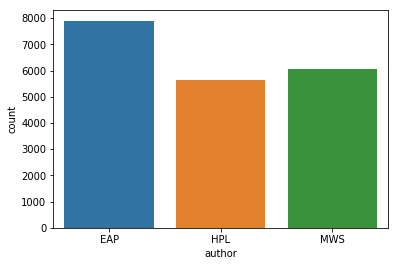

In [5]:
#проверка на разпеделението на текстовете между авторите
sns.countplot(data=train, x='author');
plt.show()

Едгар има повече данни от останалите, но техните данни са достатъчно добре разпредлени, за да не създават проблем на пръв поглед


In [7]:
#всички данни на за Едгар
eap = train[train.author == 'EAP']
eap_text = ' '.join(text for text in eap['text'])
print('Number of words in eap_text:', len(eap_text))

Number of words in eap_text: 1131484


Да го направим малко по-визуално с WordCloud

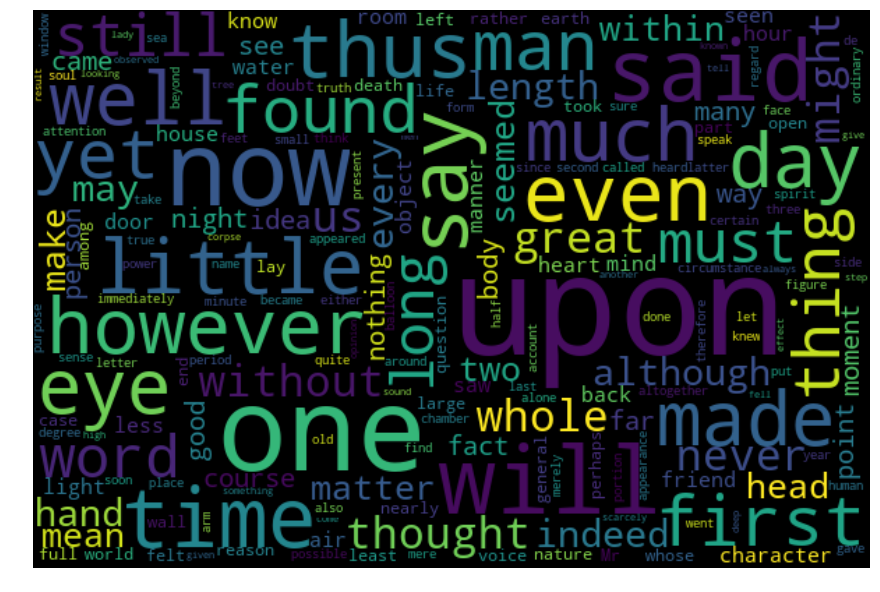

In [8]:
#думите в текстовете на Едгар
wordcloud = WordCloud(width=600, height=400,
                      random_state=40, max_font_size=100).generate(eap_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Да направим същото и за другите двама автори

In [9]:
mws = train[train.author == 'MWS']
mws_text = ' '.join(text for text in mws['text'])
print('Number of words in eap_text:', len(mws_text))

Number of words in eap_text: 922675


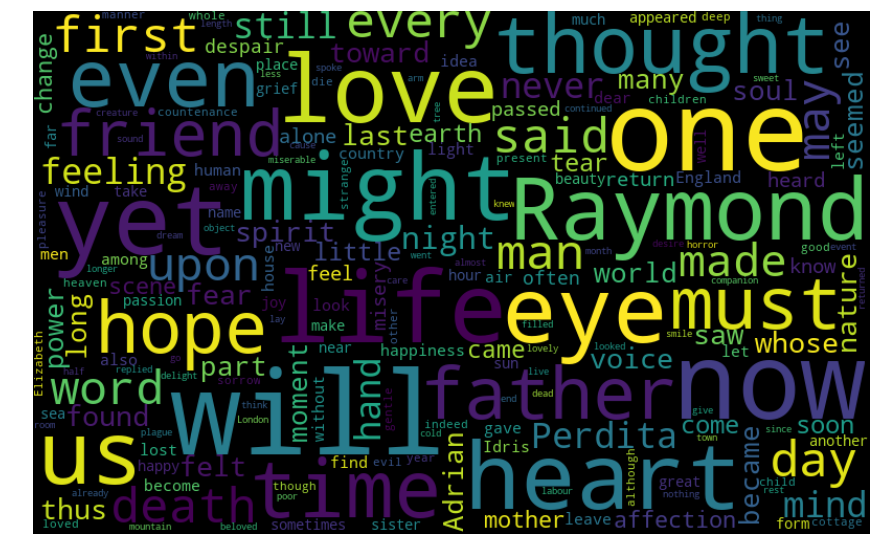

In [10]:
wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(mws_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Последен е Хауърд

In [11]:
hpl = train[train.author == 'HPL']
hpl_text = ' '.join(text for text in hpl['text'])
print('Number of words in eap_text:', len(hpl_text))

Number of words in eap_text: 883812


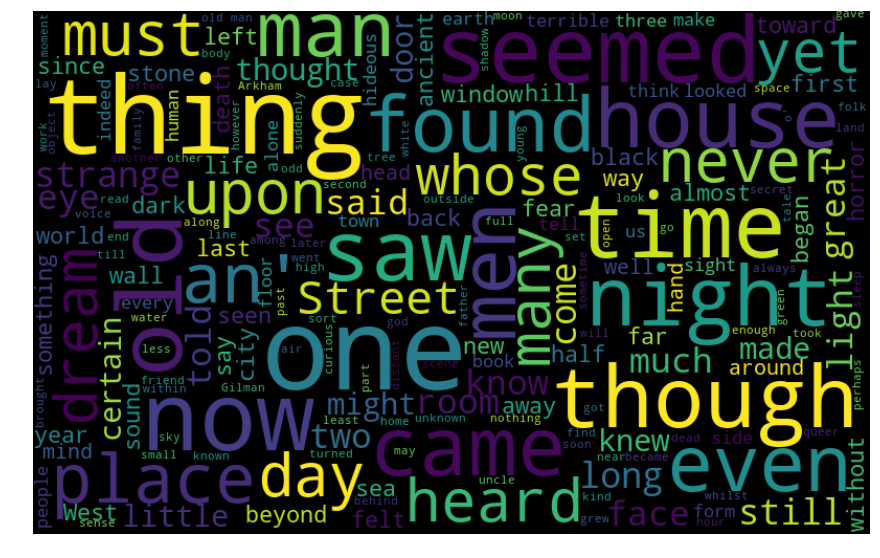

In [12]:
# Word cloud for H.P. Lovecraft
# default width=400, height=200
wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(hpl_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [13]:
#запазваме си копие от тренировъчните и тестовите данни
temp_train = train.copy()
temp_test = test.copy()

In [14]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [23]:
import nltk
# nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
punctuations = string.punctuation
# премахване на лични местоимения, препинателни знаци и междуметие
def clean(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Преработени %d от %d текста." % (counter, len(docs)))
        counter += 1 
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords  and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

## Малко статистика за думите
---
1. Взимаме текстовете по автор
2. Изчистваме ги
4. Показваме най-често срещаите

In [24]:
#данни по автор
eap_text = [text for text in train[train.author == 'EAP']['text']]
hpl_text = [text for text in train[train.author == 'HPL']['text']]
mws_text = [text for text in train[train.author == 'MWS']['text']]

#изчистване и групиране на думите
eap_clean = clean(eap_text)
eap_clean = ' '.join(eap_clean).split()

hpl_clean = clean(hpl_text)
hpl_clean = ' '.join(hpl_clean).split()

mws_clean = clean(mws_text)
mws_clean = ' '.join(mws_clean).split()

#разпределение на думите
eap_counts = Counter(eap_clean)
hpl_counts = Counter(hpl_clean)
mws_counts = Counter(mws_clean)

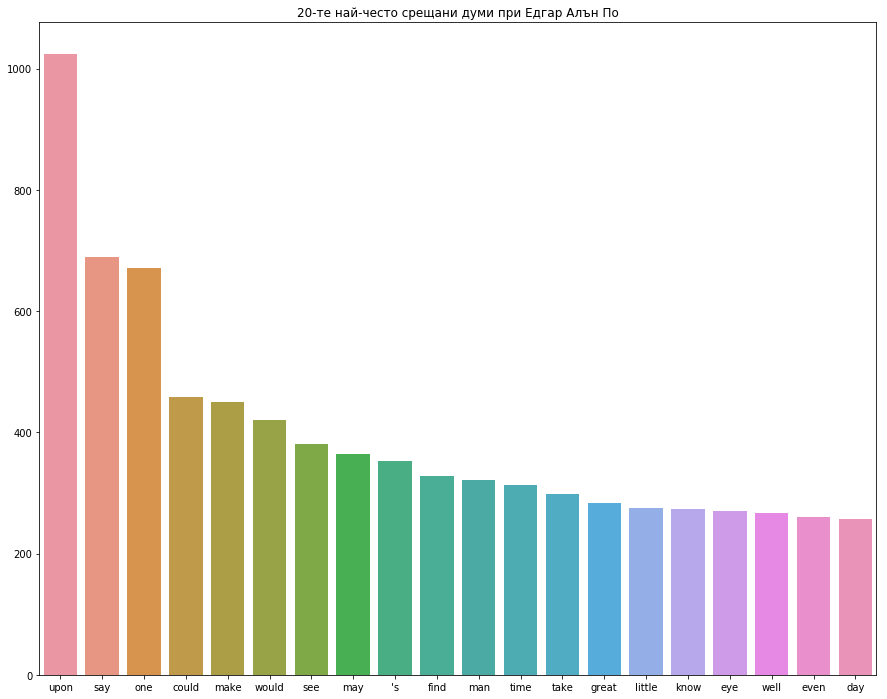

In [26]:
# 20-те най-често срещани думи при Едгар Алън По
eap_common_words = [word[0] for word in eap_counts.most_common(20)]
eap_common_counts = [word[1] for word in eap_counts.most_common(20)]

plt.figure(figsize=(15, 12))

sns.barplot(x=eap_common_words, y=eap_common_counts)
plt.title('20-те най-често срещани думи при Едгар Алън По')
plt.show()

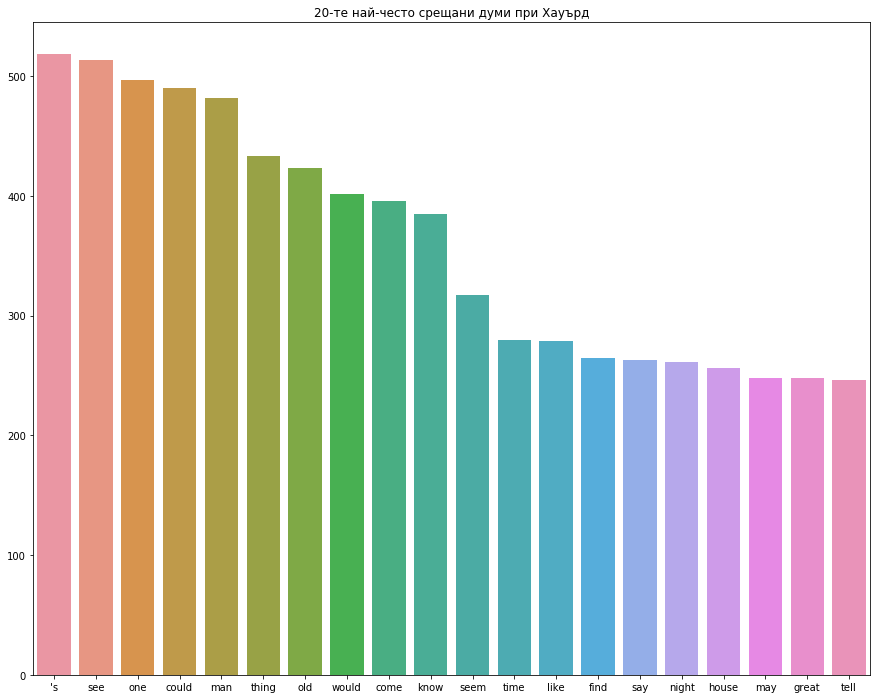

In [27]:
# 20-те най-често срещани думи при Хауърд
hpl_common_words = [word[0] for word in hpl_counts.most_common(20)]
hpl_common_counts = [word[1] for word in hpl_counts.most_common(20)]

plt.figure(figsize=(15, 12))
sns.barplot(x=hpl_common_words, y=hpl_common_counts)
plt.title('20-те най-често срещани думи при Хауърд')
plt.show()

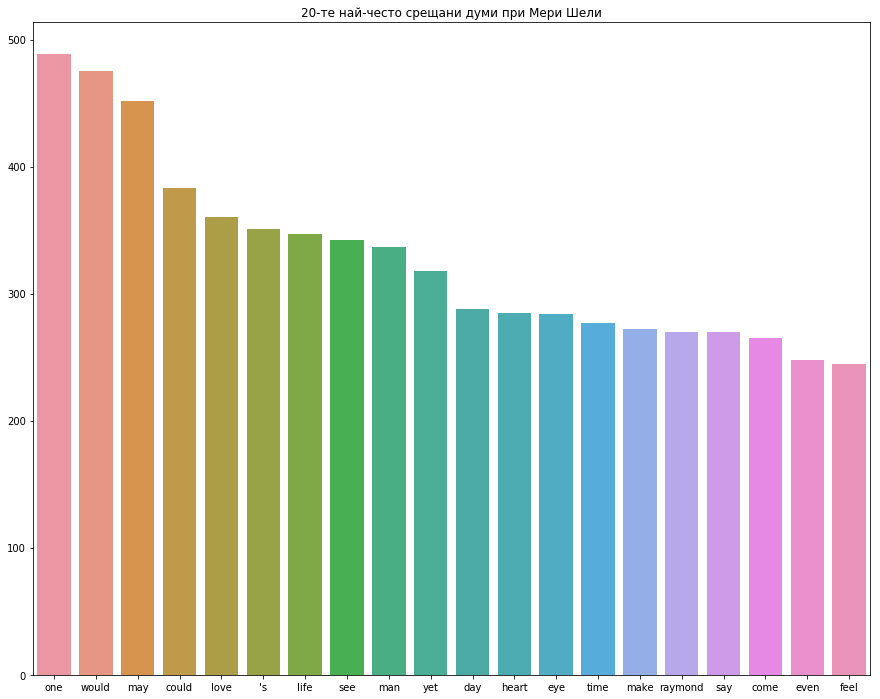

In [28]:
# 20-те най-често срещани думи при Мери Шели
mws_common_words = [word[0] for word in mws_counts.most_common(20)]
mws_common_counts = [word[1] for word in mws_counts.most_common(20)]

plt.figure(figsize=(15, 12))
sns.barplot(x=mws_common_words, y=mws_common_counts)
plt.title('20-те най-често срещани думи при Мери Шели')
plt.show()

In [29]:
# Показване на всички
print(eap_counts.most_common(25))
print()
print(hpl_counts.most_common(25))
print()
print(mws_counts.most_common(25))

[('upon', 1025), ('say', 689), ('one', 671), ('could', 458), ('make', 450), ('would', 420), ('see', 381), ('may', 364), ("'s", 353), ('find', 328), ('man', 321), ('time', 313), ('take', 298), ('great', 284), ('little', 275), ('know', 274), ('eye', 270), ('well', 267), ('even', 261), ('day', 257), ('however', 254), ('thus', 254), ('first', 249), ('long', 235), ('yet', 232)]

[("'s", 519), ('see', 514), ('one', 497), ('could', 490), ('man', 482), ('thing', 433), ('old', 423), ('would', 402), ('come', 396), ('know', 385), ('seem', 317), ('time', 280), ('like', 279), ('find', 265), ('say', 263), ('night', 261), ('house', 256), ('may', 248), ('great', 248), ('tell', 246), ('make', 237), ('go', 235), ('though', 234), ('hear', 223), ('look', 209)]

[('one', 489), ('would', 475), ('may', 452), ('could', 383), ('love', 360), ("'s", 351), ('life', 347), ('see', 342), ('man', 337), ('yet', 318), ('day', 288), ('heart', 285), ('eye', 284), ('time', 277), ('make', 272), ('raymond', 270), ('say', 27

От графиките се вижда нещо интересно, знакът за притежание "'s" се използва доста често и може да се счита по-скоро за шум. Да го махнем.

In [35]:
eap_clean = [word for word in eap_clean if word != '\'s']
hpl_clean = [word for word in eap_clean if word != '\'s']
mws_clean = [word for word in eap_clean if word != '\'s']

eap_counts = Counter(eap_clean)
hpl_counts = Counter(hpl_clean)
mws_counts = Counter(mws_clean)


In [36]:
#чистене на тренировъчните данни
train_cleaned = clean(train['text'], logging=True)


Преработени 1000 от 19579 текста.
Преработени 2000 от 19579 текста.
Преработени 3000 от 19579 текста.
Преработени 4000 от 19579 текста.
Преработени 5000 от 19579 текста.
Преработени 6000 от 19579 текста.
Преработени 7000 от 19579 текста.
Преработени 8000 от 19579 текста.
Преработени 9000 от 19579 текста.
Преработени 10000 от 19579 текста.
Преработени 11000 от 19579 текста.
Преработени 12000 от 19579 текста.
Преработени 13000 от 19579 текста.
Преработени 14000 от 19579 текста.
Преработени 15000 от 19579 текста.
Преработени 16000 от 19579 текста.
Преработени 17000 от 19579 текста.
Преработени 18000 от 19579 текста.
Преработени 19000 от 19579 текста.


In [40]:
# Парсване на текстовете във вектор
print('Трансформиране')


train_vec = []
for doc in nlp.pipe(train_cleaned, batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))
        
train_vec = np.array(train_vec)

Parsing documents...


# Word2Vec

Да тренираме word2vec model върху всичките данни и да си направим "вмъкване на думи"(word embeding) oт модела. Този модел се справя добре с изречение, в този случай трябва да върнем междуметията и местоименията, защото те дават контекст. Ще променим функцията clean()

In [41]:
#комбинация на всички данни
all_text = np.concatenate((train['text'], test['text']), axis=0)
all_text = pd.DataFrame(all_text, columns=['text'])
print('Number of total text documents:', len(all_text))

Number of total text documents: 27971


In [42]:
def clean_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Преработени %d от %d текста." % (counter, len(docs)))
        doc = nlp(doc, disable=['tagger'])
        #лематицация на думите() и само с малки букви
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # разделяне на изреченито, спрямо пунктуацията
        doc = re.split("[\.?!;] ", doc)
        # премахване на препинателните знаци
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # разделяне на думи
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [43]:
train_cleaned_word2vec = clean_word2vec(all_text['text'], logging=True)

Преработени 1000 от 27971 текста.
Преработени 2000 от 27971 текста.
Преработени 3000 от 27971 текста.
Преработени 4000 от 27971 текста.
Преработени 5000 от 27971 текста.
Преработени 6000 от 27971 текста.
Преработени 7000 от 27971 текста.
Преработени 8000 от 27971 текста.
Преработени 9000 от 27971 текста.
Преработени 10000 от 27971 текста.
Преработени 11000 от 27971 текста.
Преработени 12000 от 27971 текста.
Преработени 13000 от 27971 текста.
Преработени 14000 от 27971 текста.
Преработени 15000 от 27971 текста.
Преработени 16000 от 27971 текста.
Преработени 17000 от 27971 текста.
Преработени 18000 от 27971 текста.
Преработени 19000 от 27971 текста.
Преработени 20000 от 27971 текста.
Преработени 21000 от 27971 текста.
Преработени 22000 от 27971 текста.
Преработени 23000 от 27971 текста.
Преработени 24000 от 27971 текста.
Преработени 25000 от 27971 текста.
Преработени 26000 от 27971 текста.
Преработени 27000 от 27971 текста.



<strong>Да създадем и натренираме Word2Vec модел със следните параметри:</strong>
* size: Word vector dimensionality size is 300
* window: Maximum distance between center word and predicted word in a sentence
* min_count: Ignore all words that appear with less frequency than this
* workers: Use this many workers to train model. Leads to faster training on multi-core machines
* sg: Define archetecture. 1 for skip-gram, 0 for continouous bag of words (CBOW).

In [47]:
from gensim.models.word2vec import Word2Vec
print("Трениране на Word2Vec модел...")
wordvec_model = Word2Vec(train_cleaned_word2vec, size=300, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec моделът е създаден.")


Трениране на Word2Vec модел...
Word2Vec моделът е създаден.


In [48]:
# Създаване на вектори от изчистени думи
def create_average_vec(doc):
    average = np.zeros((300,), dtype='float32')
    num_words = 0.
    for word in doc.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [50]:
# Създаване на вектори
train_cleaned_vec = np.zeros((train.shape[0], 300), dtype="float32")  # 19579 x 300
for i in range(len(train_cleaned)):
    train_cleaned_vec[i] = create_average_vec(train_cleaned[i])

print("Форма на тренировъчният вектор:", train_cleaned_vec.shape)

Форма на тренировъчният вектор: (19579, 300)


# One-Hot Encode Labels


In [53]:
from sklearn.preprocessing import label_binarize

y_train_ohe = label_binarize(train['author'], classes=['EAP', 'HPL', 'MWS'])
print('y_train_ohe samples:')
print(y_train_ohe[:5])

y_train_ohe shape: (19579, 3)
y_train_ohe samples:
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]


# Split into Train/Test Datasets


In [54]:
from sklearn.model_selection import train_test_split

# данни с по-лош резултат
# X_train, X_test, y_train, y_test = train_test_split(train_vec, y_train_ohe, test_size=0.2, random_state=21)
# Използваме Word2Vec
X_train, X_test, y_train, y_test = train_test_split(train_cleaned_vec, y_train_ohe, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (15663, 300)
X_test size: (3916, 300)
y_train size: (15663, 3)
y_test size: (3916, 3)


# Deep Learning with Keras

Дефинираме невронна мрежа с [keras](http://keras.io/), която е питонска библиотека за deep learning. Използва се многослойна невронна мрежа с 4 скрити слоя, с релу активация.
Има още 4 drop out слоеве, за да се избегне overfitting.

In [89]:
def initiate(architecture='mlp'):
    model = Sequential()
    # Densely Connected Neural Network (Multi-Layer Perceptron)
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=300))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    #softmax за да върне резултати със сбор от вероятности 1
    model.add(Dense(3, activation='softmax'))
    return model

In [90]:
# Дефиниране на модел, ползваме многослойно невронни мрежи, защото са бързи
model = initiate('mlp')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               154112    
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
__________

In [91]:
# Компилиране на модела с оптимизатор sgd, пробвах с Adagrad и Adam
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])

In [92]:
epochs = 10

estimator = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=epochs, batch_size=128, verbose=2)

Train on 12530 samples, validate on 3133 samples
Epoch 1/10
 - 5s - loss: 0.9626 - acc: 0.5298 - val_loss: 0.7746 - val_acc: 0.6636
Epoch 2/10
 - 4s - loss: 0.7447 - acc: 0.6852 - val_loss: 0.6923 - val_acc: 0.7201
Epoch 3/10
 - 4s - loss: 0.6909 - acc: 0.7085 - val_loss: 0.6745 - val_acc: 0.7271
Epoch 4/10
 - 4s - loss: 0.6706 - acc: 0.7223 - val_loss: 0.6619 - val_acc: 0.7328
Epoch 5/10
 - 4s - loss: 0.6618 - acc: 0.7244 - val_loss: 0.6605 - val_acc: 0.7341
Epoch 6/10
 - 4s - loss: 0.6583 - acc: 0.7302 - val_loss: 0.6571 - val_acc: 0.7338
Epoch 7/10
 - 4s - loss: 0.6505 - acc: 0.7334 - val_loss: 0.6615 - val_acc: 0.7344
Epoch 8/10
 - 4s - loss: 0.6489 - acc: 0.7341 - val_loss: 0.6525 - val_acc: 0.7354
Epoch 9/10
 - 4s - loss: 0.6453 - acc: 0.7333 - val_loss: 0.6540 - val_acc: 0.7322
Epoch 10/10
 - 4s - loss: 0.6396 - acc: 0.7373 - val_loss: 0.6536 - val_acc: 0.7312


In [93]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 73.73% / Validation accuracy: 73.12%


In [97]:
# Да предсказваме
predicted_prob = model.predict(X_test)
print(predicted_prob.shape)

(3916, 3)


In [98]:
# Запазване на файл за предаване
with open('submissions.csv', 'w') as file_obj:
    file_obj.write('ID,EAP,HPL,MWS\n')
    for pred in range(len(predicted_prob)):
        file_obj.write(str(pred+1) + ',' + ','.join('{:.2f}'.format(s) for s in predicted_prob[pred].tolist()) + '\n')

In [99]:
# Принтираме колко е лог-лоса, нагативни резултати за истински стойности
loss_sk = log_loss(y_test, predicted_prob)
print('Log loss is: {}'.format(loss_sk))

Log loss is: 0.6439448985337093


<strong>Други подходи, които можем да имплементираме за тази задача са:</strong>
* CountVectorizer за характеристики в комбинация с  различни класификатори (LinearSVC, Logistic Regression, Random Forest)
* TfidfVectorizer - Добри резултати се получават с MultinomialNB и TfidfVectorizer

<strong>Подобрение може да се направи като се :</strong>
* Добавят различни слоеве, с различни активации и оптимизатори (хиперпараметри)
* Използват се някакво общи черти на авторите(дали са съвременници, виждаме, че дамата е от Англия, а мъжете от САЩ)
* Използване на комбинация от множество класификатори